In [1]:
import copy
from functools import partial
from typing import Optional, Union

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist
from scipy.stats import gaussian_kde
import torch
from torch import nn
from torch.utils.data import Dataset
import torchvision
from tqdm.notebook import tqdm

from frouros.callbacks import PermutationTestDistanceBased
from frouros.detectors.data_drift import MMD
from frouros.utils.kernels import rbf_kernel

# MNIST dataset

A more advanced example is shown below, where MMD {cite:p}`JMLR:v13:gretton12a` is applied as a drift detector to the well-known [MNIST](http://yann.lecun.com/exdb/mnist/) image dataset.

The goal is to apply [GaussianBlur](https://pytorch.org/vision/stable/generated/torchvision.transforms.GaussianBlur.html#gaussianblur) and [ElasticTransform](https://pytorch.org/vision/0.15/generated/torchvision.transforms.ElasticTransform.html#elastictransform) transformations to some of the images in order to simulate a drift process at the feature level (data drift) that would likely end up affecting the performance of a hypothetical machine learning model.

In order to ensure reproducibility, a `set_seed` function is used, as well as specifying the device for PyTorch operations (CPU or GPU).

In [2]:
def set_seed(seed=31):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)

In [3]:
seed = 31
set_seed(seed=seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Data is split as follows:

- **Train:** These images are exclusively used to train an autoencoder, reducing the dimensionality from 784 (28x28x1) to 5 dimensions through the encoder function $\phi : \mathbb{R}^{28x28x1} \rightarrow \mathbb{R}^{5}$. The encoder $\phi$ processes 30,000 samples.

- **Reference:** These images represent samples from the training distribution and serve as a reference. There are 30,000 samples in this set.

- **Test:** These images may belong to the original distribution of the data or undergo some of the transformations mentioned above. This set consists of 10,000 samples.

In [4]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),  # Convert images to the range [0.0, 1.0] (normalize)
    ]
)

batch_size = 64

train_all_dataset = torchvision.datasets.MNIST(
    root="/tmp/mnist/train/",
    train=True,
    download=True,
    transform=transform,
)

train_all_dataset_size = len(train_all_dataset)
train_dataset_size = int(train_all_dataset_size * 0.5)
reference_dataset_size = train_all_dataset_size - train_dataset_size

train_dataset, reference_dataset = torch.utils.data.random_split(dataset=train_all_dataset, lengths=[train_dataset_size, reference_dataset_size], generator=torch.Generator().manual_seed(31))

train_data_loader = torch.utils.data.DataLoader(  # 30000 samples to train the autoencoder
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

Examples of MNIST images that will be used to train the autoencoder are shown.

In [5]:
def imshow(img):
    npimg = img.numpy()
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap=plt.cm.gray)
    fig.tight_layout()
    plt.show()

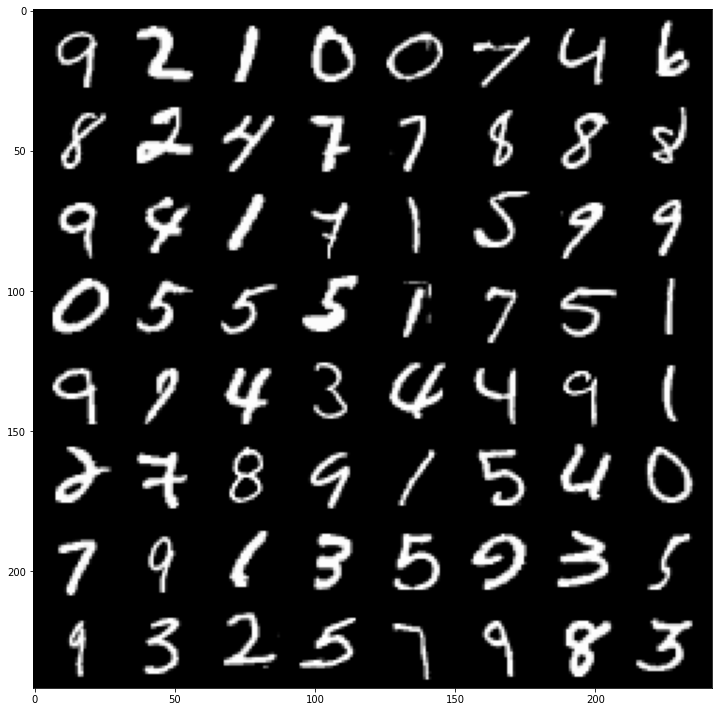

In [6]:
dataiter = iter(train_data_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

The autoencoder is composed of the following parts:

First, an encoder is implemented with a straightforward architecture. It consists of a convolutional section, followed by a flatten layer, and finally, a pair of standard hidden layers that map the output of the convolutional section to the desired latent space.

In [7]:
class Encoder(nn.Module):

    def __init__(self, latent_dim: int):
        super().__init__()

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1)

        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, latent_dim)
        )

    def forward(self, x):
        x = self.encoder_conv(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

The decoder performs the reverse process of the encoder to reconstruct the initial dimensionality from the encoder output.

In [8]:
class Decoder(nn.Module):

    def __init__(self, latent_dim: int):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1,
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3,
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2,
            padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

These two blocks combine to form the complete autoencoder architecture.

In [9]:
class Autoencoder(nn.Module):

    def __init__(self, latent_dim: int) -> None:
        super().__init__()
        self.encoder = Encoder(
            latent_dim=latent_dim,
        )
        self.decoder = Decoder(
            latent_dim=latent_dim,
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

As mentioned earlier, the bottleneck dimension of the autoencoder is set to 5.

In [10]:
latent_dim = 5

autoencoder = Autoencoder(
    latent_dim=latent_dim,
)

To prevent the autoencoder from simply learning to copy the input to the output (acting as an identity function), we implement the contractive loss as a regularizer to learn a meaningful representation of the input in the bottleneck dimensions {cite:p}`rifai2011contractive`. For optimization, Adam {cite:p}`kingma2014adam` is used.

In [11]:
def contractive_loss(outputs_e, outputs, inputs, lamda = 1e-4):
    assert outputs.shape == inputs.shape ,f'outputs.shape : {outputs.shape} != inputs.shape : {inputs.shape}'
    criterion = nn.MSELoss()
    loss1 = criterion(outputs, inputs)

    outputs_e.backward(torch.ones(outputs_e.size()), retain_graph=True)
    loss2 = torch.sqrt(torch.sum(torch.pow(inputs.grad, 2)))
    inputs.grad.data.zero_()

    loss = loss1 + (lamda*loss2)
    return loss

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

The autoencoder is trained for 3 epochs, with the loss printed every 100 batches of images.

In [12]:
epochs = 3

for epoch in range(epochs):

    running_loss = 0.0
    for i, (inputs, _) in enumerate(train_data_loader, 0):
        inputs.requires_grad = True
        inputs.retain_grad()

        outputs_e, outputs = autoencoder(inputs)
        loss = contractive_loss(outputs_e, outputs, inputs)

        inputs.requires_grad = False

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

[1,   100] loss: 0.156
[1,   200] loss: 0.086
[1,   300] loss: 0.056
[1,   400] loss: 0.044
[2,   100] loss: 0.036
[2,   200] loss: 0.034
[2,   300] loss: 0.033
[2,   400] loss: 0.032
[3,   100] loss: 0.031
[3,   200] loss: 0.030
[3,   300] loss: 0.030
[3,   400] loss: 0.029


A sample is shown below, featuring the reconstruction made by the autoencoder from the 5 dimensions.

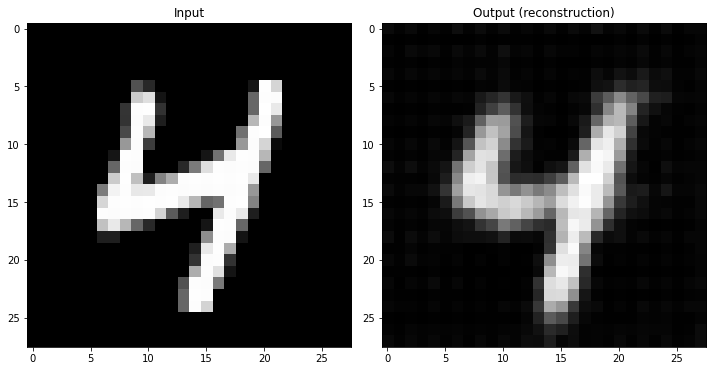

In [13]:
sample = reference_dataset[1][0]  # Sample not seen by the autoencoder during training
_, X_reconstructed = autoencoder(sample.unsqueeze(0))
X_reconstructed = torch.squeeze(X_reconstructed, axis=0)

fig, axs = plt.subplots(nrows=1,
                        ncols=2,
                        figsize=(10, 10))

axs[0].set_title("Input")
axs[0].imshow(np.transpose(sample, (1, 2, 0)), cmap=plt.cm.gray)

axs[1].set_title("Output (reconstruction)")
axs[1].imshow(np.transpose(X_reconstructed.detach(), (1, 2, 0)), cmap=plt.cm.gray)

fig.tight_layout()
plt.show()

In [14]:
test_dataset = torchvision.datasets.MNIST(
    root="/tmp/mnist/test/",
    train=False,
    download=True,
)

To apply each transformation to the images, a custom dataset class is utilized.

In [15]:
class CustomMNIST(Dataset):

    def __init__(
        self,
        subset,
        transform: Optional[Union[torch.nn.Module, torchvision.transforms.Compose]] = None
    ) -> None:
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self) -> int:
        return len(self.subset)

In [16]:
gaussian_blur_dataset = CustomMNIST(
    subset=test_dataset,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.GaussianBlur(
                kernel_size=(5, 9),
                sigma=1.25,
            ),
            torchvision.transforms.ToTensor(),
        ],
    ),
)

elastic_transform_dataset = CustomMNIST(
    subset=test_dataset,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ElasticTransform(
                alpha=60.0,
                sigma=5.0,
            ),
            torchvision.transforms.ToTensor(),
        ],
    ),
)

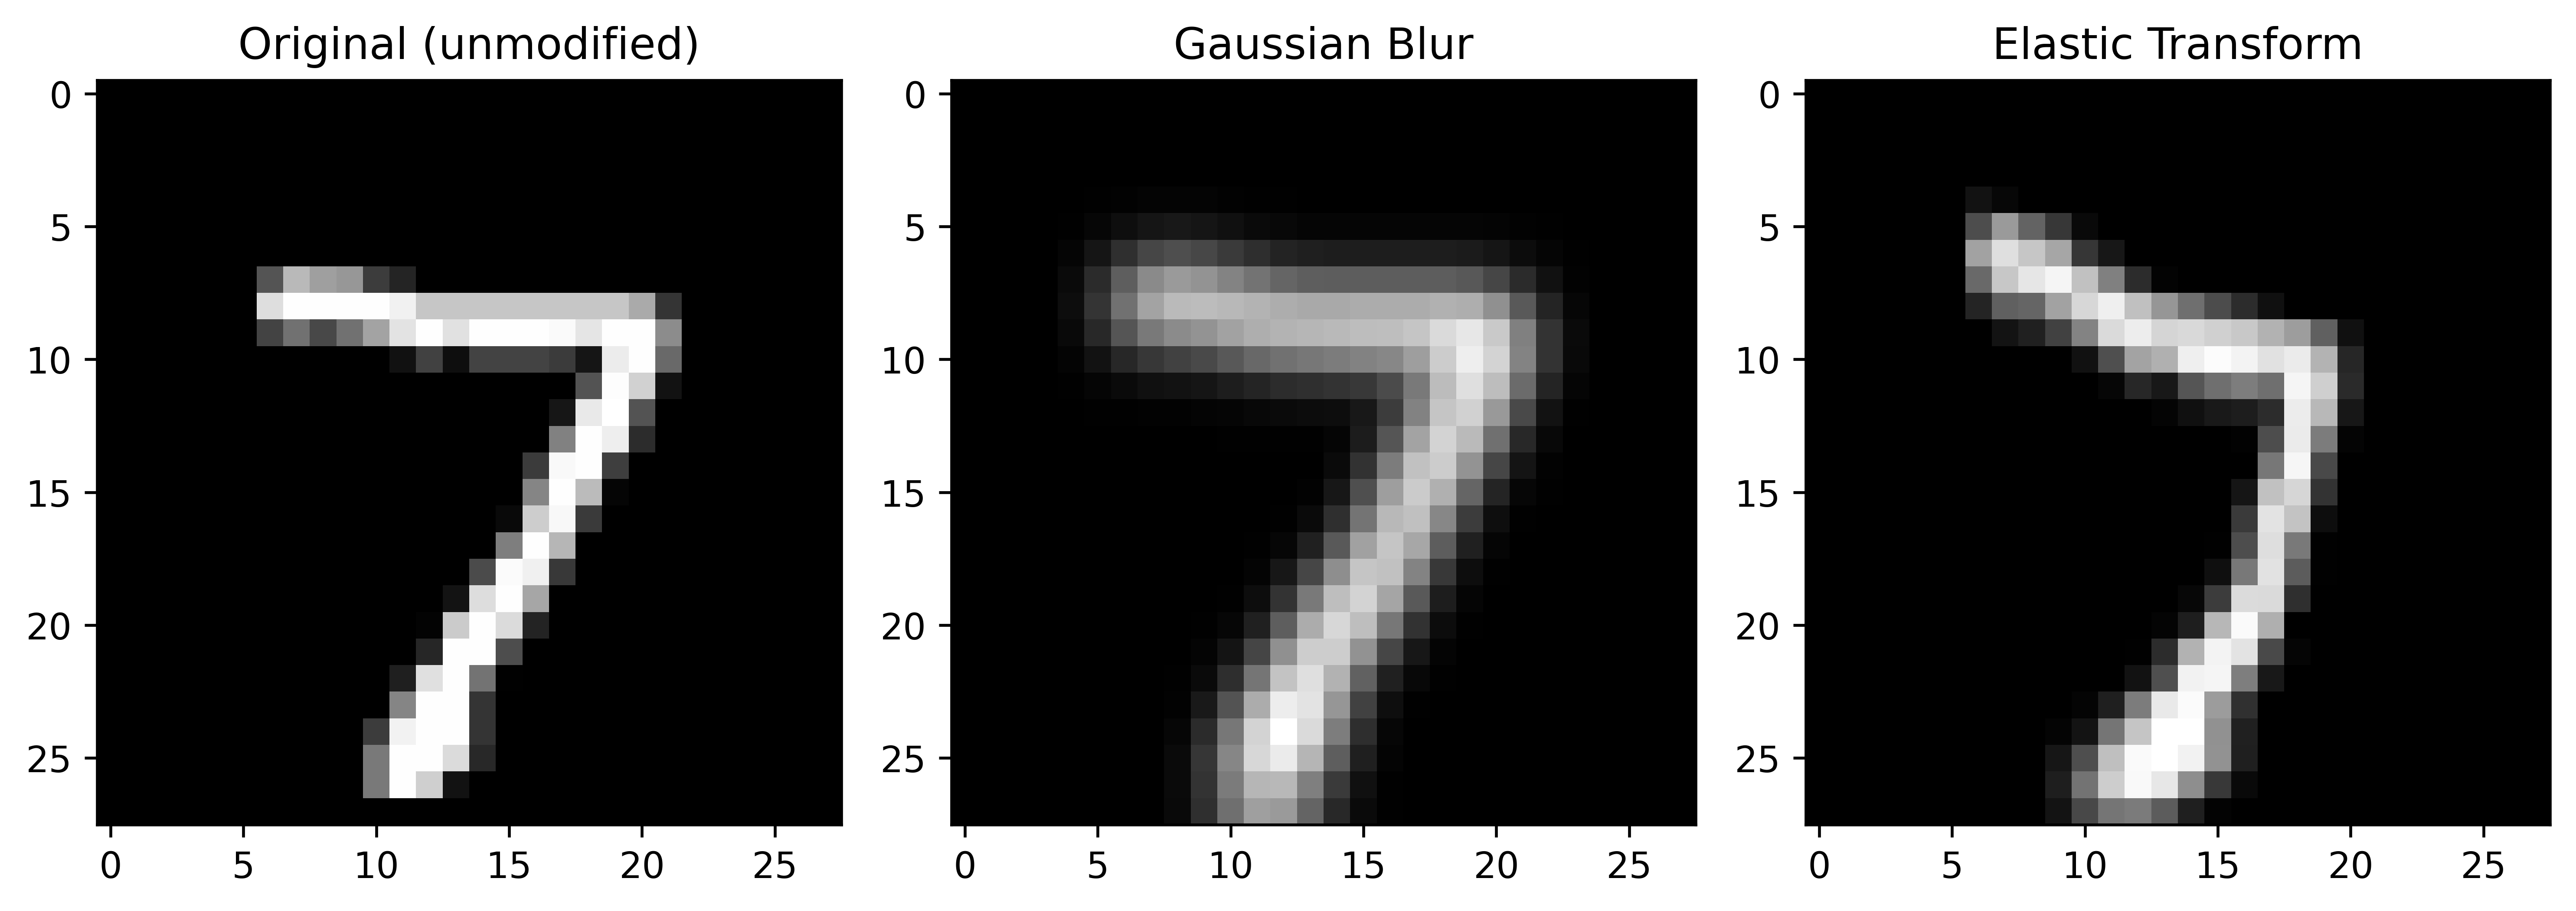

In [17]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(10, 10),
    dpi=600,
)

for ax, img, title in zip(axs.flat,
                          [torchvision.transforms.ToTensor()(test_dataset[0][0]),
                           gaussian_blur_dataset[0][0],
                           elastic_transform_dataset[0][0]],
                          ["Original (unmodified)",
                           "Gaussian Blur",
                           "Elastic Transform"]):
    ax.imshow(np.transpose(img, (1, 2, 0)), cmap=plt.cm.gray)
    ax.set_title(title)

fig.tight_layout()
plt.show()

**Note:**
Only 1000 samples from the reference dataset out of the 30000 available are used to fit the detector, along with 1000 samples from each of the three test datasets (original, Gaussian blur, and elastic transform). This limitation is due to the high memory requirements imposed by MMD.

In [18]:
num_samples = 1000

idx_ref_sample = np.random.choice(np.arange(0, len(reference_dataset)), size=num_samples, replace=False)
X_ref_sample = np.array([X_sample.tolist() for X_sample, _ in tqdm(torch.utils.data.Subset(reference_dataset, idx_ref_sample))]).astype(np.float32)

idx_test_sample = np.random.choice(np.arange(0, len(test_dataset)), size=num_samples, replace=False)
X_test_original_sample = np.array([torchvision.transforms.ToTensor()(X_sample).tolist() for X_sample, _ in tqdm(torch.utils.data.Subset(test_dataset, idx_test_sample))]).astype(np.float32)
X_test_gaussian_blur_sample = np.array([X_sample.tolist() for X_sample, _ in tqdm(torch.utils.data.Subset(gaussian_blur_dataset, idx_test_sample))]).astype(np.float32)
X_test_elastic_transform_sample = np.array([X_sample.tolist() for X_sample, _ in tqdm(torch.utils.data.Subset(elastic_transform_dataset, idx_test_sample))]).astype(np.float32)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

The encoder part of the trained autoencoder is utilized to obtain the 5 latent dimensions of the reference dataset.

In [19]:
with torch.no_grad():
    X_ref_encoded = autoencoder.encoder(torch.Tensor(X_ref_sample)).numpy()
    
    X_test_original_encoded = autoencoder.encoder(torch.Tensor(X_test_original_sample)).numpy()
    X_test_gaussian_blur_encoded = autoencoder.encoder(torch.Tensor(X_test_gaussian_blur_sample)).numpy()
    X_test_elastic_transform_encoded = autoencoder.encoder(torch.Tensor(X_test_elastic_transform_sample)).numpy()

A significance level of $\alpha = 0.01$ is set for the hypothesis test.

In [20]:
alpha = 0.01

Maximum Mean Discrepancy (MMD) {cite:p}`JMLR:v13:gretton12a`, imported from Frouros, is utilized with a Radial Basis Function kernel (RBF), set by default in MMD. In addition to calculating the corresponding MMD statistic, the p-value is estimated using a permutation test.

**Note:**
Since a rbf kernel is used, the median of the pairwise distances between the reference dataset is used as the bandwidth parameter $\sigma$.

In [21]:
sigma = np.median(
        pdist(
            X=X_ref_encoded,
            metric="euclidean",
        )
    )
sigma

3.13367239684279

In [22]:
num_permutations = 10000

detector = MMD(
    kernel=partial(
        rbf_kernel,
        sigma=sigma,
    ),
    callbacks=[
        PermutationTestDistanceBased(
            num_permutations=num_permutations,
            random_state=seed,
            num_jobs=-1,
            name="permutation_test",
            conservative=True,
            verbose=False,
        ),
    ],
)
_ = detector.fit(X=X_ref_encoded)

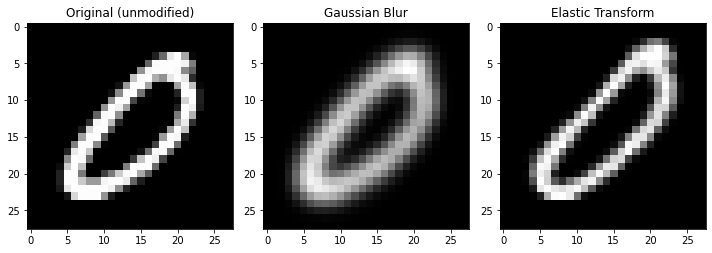

In [23]:
idx = 0

fig, axs = plt.subplots(nrows=1,
                        ncols=3,
                        figsize=(10, 10))

axs[0].set_title("Original (unmodified)")
axs[0].imshow(np.transpose(X_test_original_sample[idx], (1, 2, 0)), cmap=plt.cm.gray)

axs[1].set_title("Gaussian Blur")
axs[1].imshow(np.transpose(X_test_gaussian_blur_sample[idx], (1, 2, 0)), cmap=plt.cm.gray)

axs[2].set_title("Elastic Transform")
axs[2].imshow(np.transpose(X_test_elastic_transform_sample[idx], (1, 2, 0)), cmap=plt.cm.gray)

fig.tight_layout()
plt.show()

Compare each test dataset to the dataset fitted by MMD.

In [24]:
permutation_test_logs = {}

for sample, type_ in zip([X_test_original_encoded,
                          X_test_gaussian_blur_encoded,
                          X_test_elastic_transform_encoded],
                         ["Original (unmodified)",
                          "Gaussian Blur",
                          "Elastic Transform"]
                         ):
    mmd, callbacks_logs = detector.compare(X=sample)
    permutation_test_logs[type_] = copy.copy(callbacks_logs["permutation_test"])
    mmd, p_value = mmd.distance, callbacks_logs["permutation_test"]["p_value"]
    print(f"{type_}:\n  MMD statistic={round(mmd, 4)}, p-value={round(p_value, 4)}, drift={p_value <= alpha}")

Original (unmodified):
  MMD statistic=0.001, p-value=0.022, drift=False
Gaussian Blur:
  MMD statistic=0.0055, p-value=0.0001, drift=True
Elastic Transform:
  MMD statistic=0.0026, p-value=0.0002, drift=True


As expected, the GaussianBlur and ElasticTransform datasets exhibit a significant difference (drift) from the reference dataset. Conversely, unmodified samples are confirmed to be from the same distribution as the reference dataset (no drift).

The following graphs depict the results of the permutation tests.

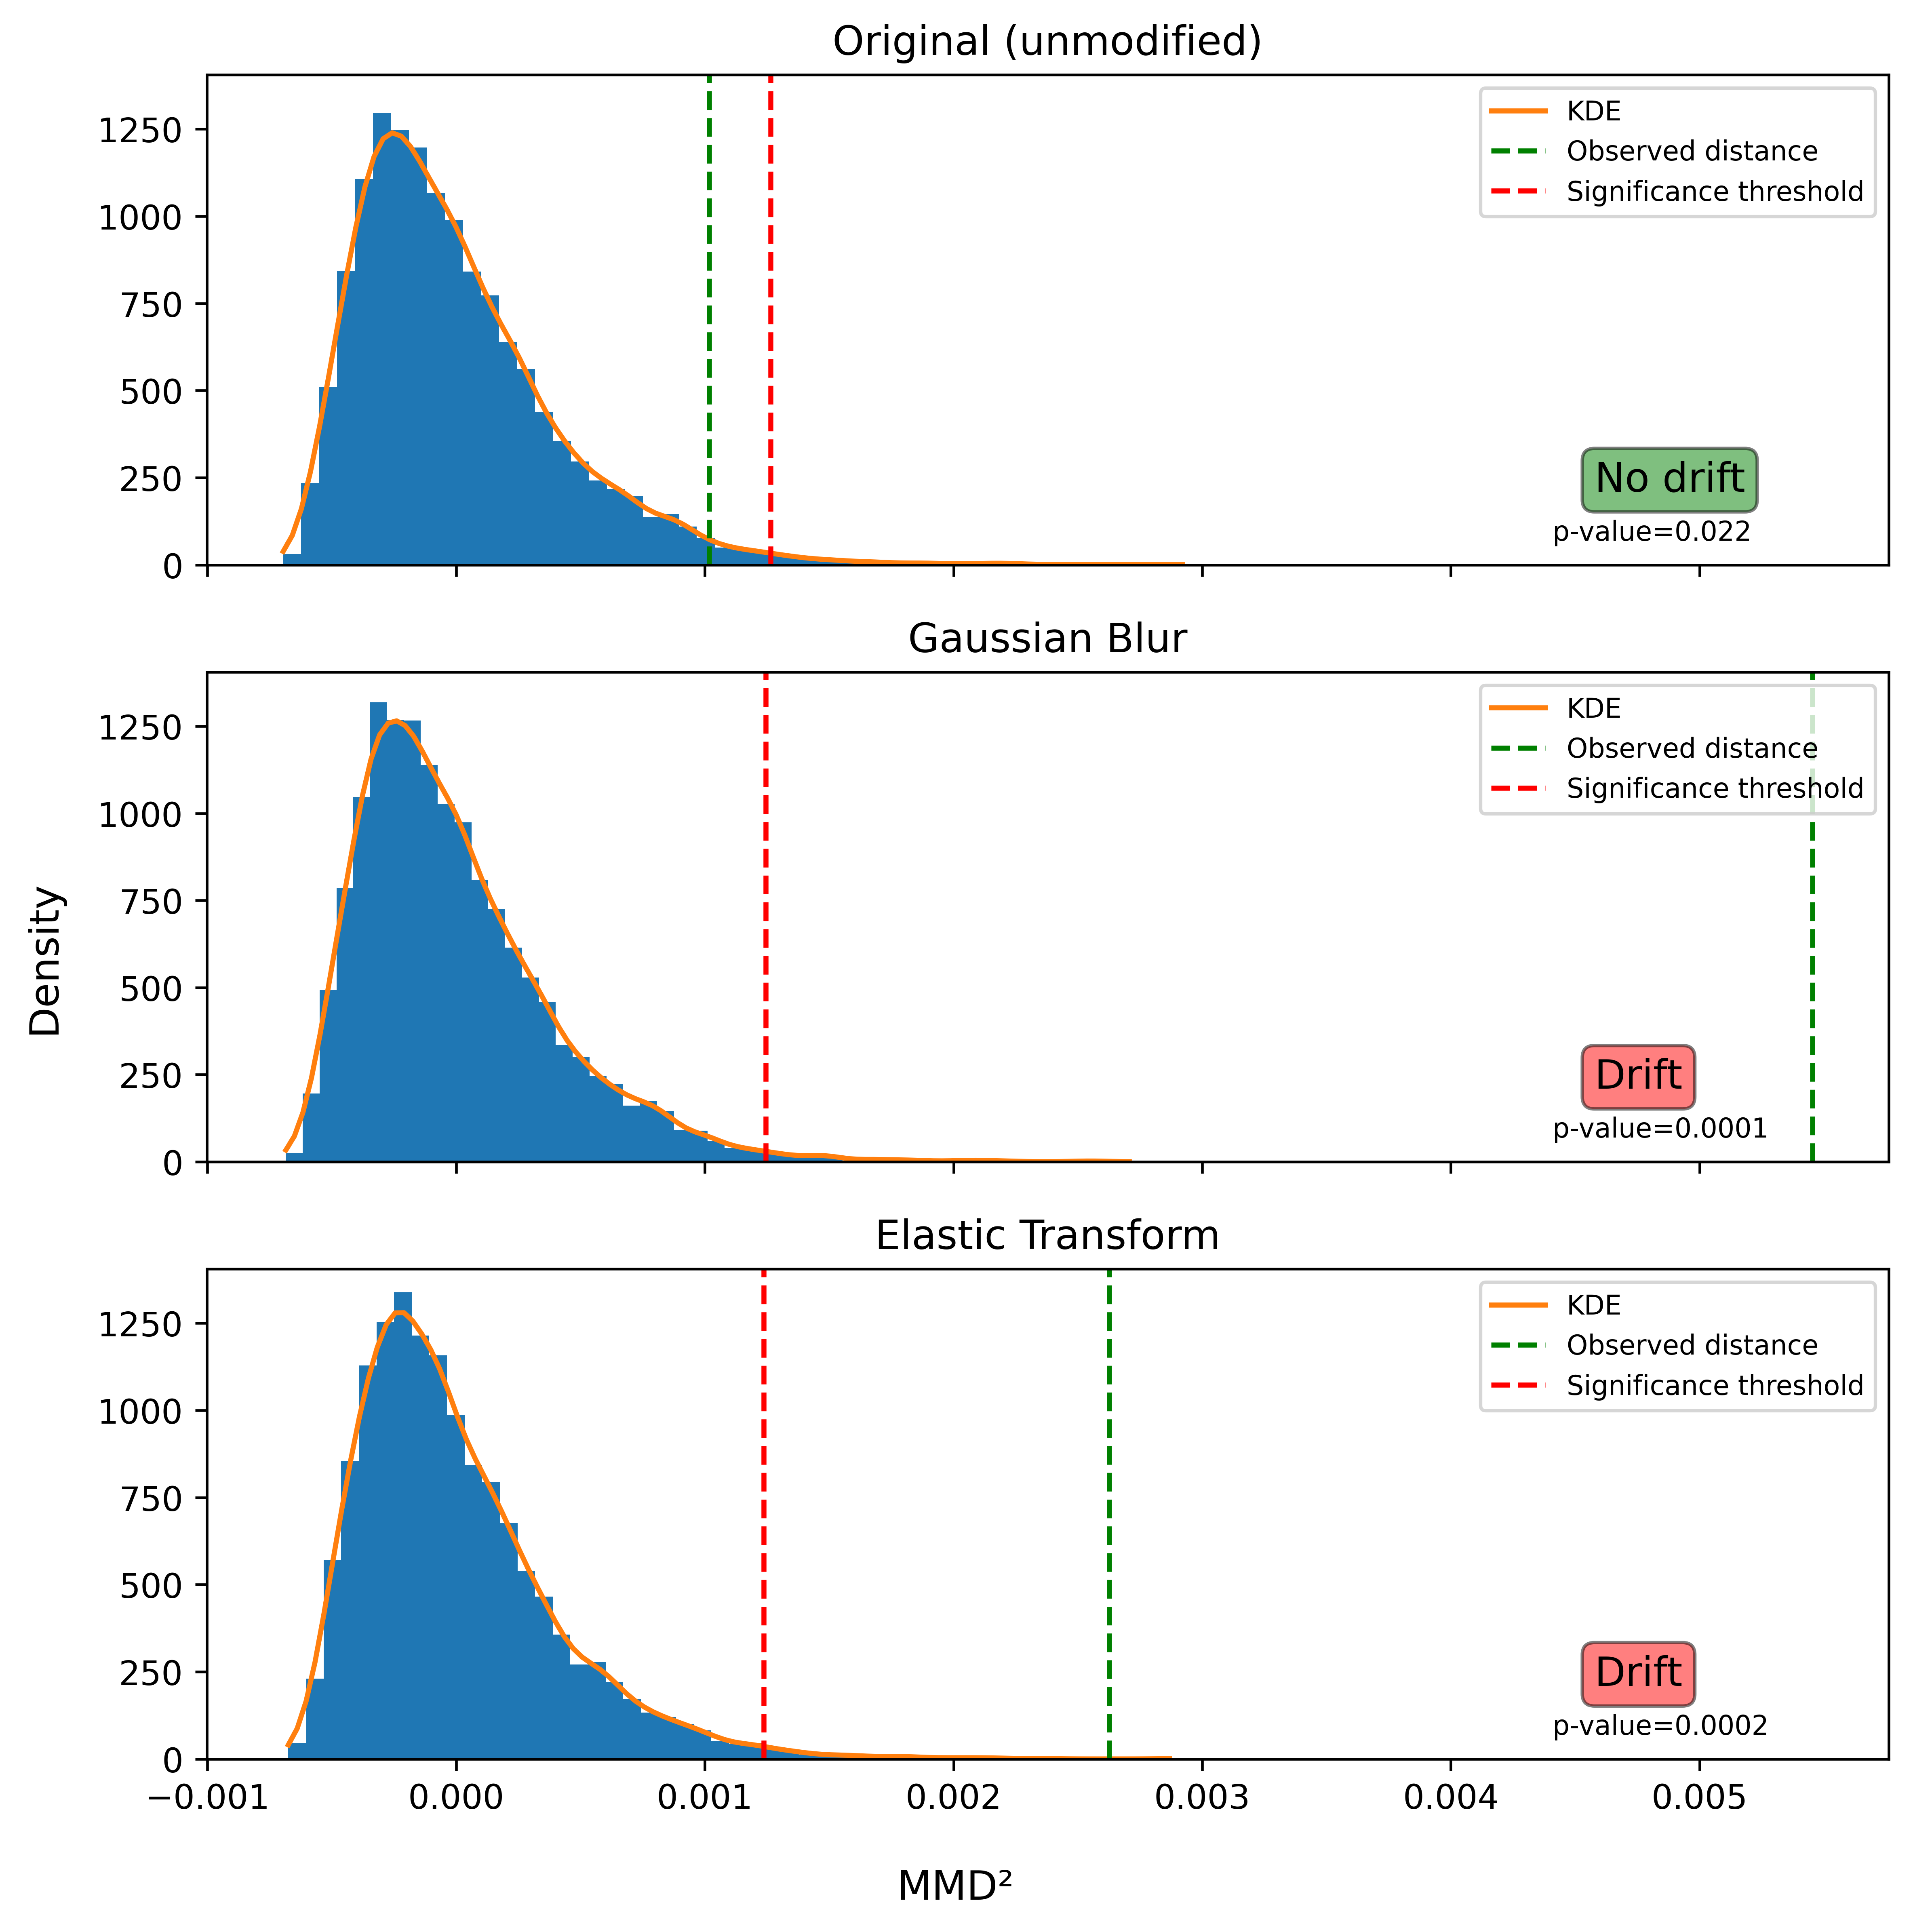

In [25]:
num_bins = 50
x_values = 100
num_percentile = 100-alpha*100

n_rows = 3
fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=1,
    figsize=(8, 8),
    sharex=True,
    sharey=True,
    dpi=600,
)

y_lim = 0.0

for ax, (type_, permutation_test) in zip(axs.flat, permutation_test_logs.items()):

    permutation_tests = permutation_test["permuted_statistics"]
    observed_statistic = permutation_test["observed_statistic"]
    p_value = permutation_test["p_value"]

    ax.hist(permutation_tests, bins=num_bins, density=True)
    xs = np.linspace(min(permutation_tests), max(permutation_tests), num=x_values)
    permutation_tests_density = gaussian_kde(permutation_tests).evaluate(xs)
    ax.plot(xs, permutation_tests_density, label="KDE")
    ax.axvline(observed_statistic, color="green", linestyle="--", label="Observed distance")
    ax.set_title(type_)
    drift = p_value <= alpha
    ax.text(0.825, 0.15, "Drift" if drift else "No drift", transform=ax.transAxes, fontsize=12, bbox={"boxstyle": "round", "facecolor": "red" if drift else "green", "alpha":0.5})
    ax.text(0.8, 0.05, f"p-value={round(p_value, 4)}", transform=ax.transAxes, fontsize=8)

    # Get the y limit
    ax_y_lim = max(ax.get_lines()[0].get_ydata())
    if y_lim < ax_y_lim:
        y_lim = ax_y_lim

# Finish plot using the y limit
for ax, (_, permutation_test) in zip(axs.flat, permutation_test_logs.items()):
    permutation_tests = permutation_test["permuted_statistics"]
    p_value = permutation_test["p_value"]

    percentile = np.percentile(permutation_tests, q=num_percentile)
    ax.axvline(percentile, color="red", linestyle="--", label="Significance threshold")
    ax.legend(fontsize=8, loc="upper right")

fig.supxlabel("MMD²")
fig.supylabel("Density")
fig.tight_layout()
plt.show()

```{bibliography}
:filter: docname in docnames
```